We will learn how to apply a type of deep learning technique called **Long Short-Term Memory (LSTM)** neural networks. Unlike standard feedforward neural networks, LSTMs encompass feedback connections that make it a "general-purpose computer". LSTMs are designed to process not only a single data point (such as images), but also entire sequences of data, e.g., such as speech, video, or financial time series.

The network will be trained on the historic daily (in-sample) returns of an exemplary financial stock. Once the network is trained, we will use the learned model to predict future (out-of-sample) returns. Finally, we will convert the predictions into tradable signals and the backtest the signals accordingly.


# 0. LIBRARIES IMPORT

In [ ]:
!pip install bt
!pip install yfinance

In [4]:
# import python data science and utility libraries
import os, sys, itertools, urllib, io
import datetime as dt
import pandas as pd
import numpy as np

# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import dataloader

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi']= 150

import bt as bt
import yfinance as yf
yf.pdr_override()


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<ipython-input-4-9b54f146af94>:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Import Google's `GDrive` connector and mount your `GDrive` directories:

In [6]:
# import the Google Colab GDrive connector
from google.colab import drive

# mount GDrive inside the Colab notebook
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# create Colab Notebooks directory
notebook_directory = '/content/drive/MyDrive/Colab Notebooks'
if not os.path.exists(notebook_directory): os.makedirs(notebook_directory)

 # create data sub-directory inside the Colab Notebooks directory
data_directory = '/content/drive/MyDrive/Colab Notebooks/data'
if not os.path.exists(data_directory): os.makedirs(data_directory)

 # create models sub-directory inside the Colab Notebooks directory
models_directory = '/content/drive/MyDrive/Colab Notebooks/models'
if not os.path.exists(models_directory): os.makedirs(models_directory)

In [8]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value); # set pytorch seed CPU

Enable GPU computing:

In [10]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
print('Notebook with \'{}\' computation enabled'.format(str(device)))

Notebook with 'cpu' computation enabled


In [ ]:
!nvidia-smi

# 1. DATA PROCESSING

We will aquire historic daily stock market data of the "International Business Machines" (IBM) corporation (ticker symbol: "IBM").

In [11]:
start_date = dt.datetime(2000, 1, 1)
end_date = dt.datetime(2017, 12, 31)

# download ibm market data
stock_data = yf.download('IBM', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [12]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,107.492828,110.898659,106.955070,110.898659,60.474819,10823694
2000-01-04,108.986618,109.464630,105.999046,107.134323,58.422092,8606279
2000-01-05,107.970840,114.483749,107.194077,110.898659,60.474819,13318927
2000-01-06,112.810707,113.706978,108.508606,108.986618,59.432117,8338607
2000-01-07,112.093689,112.750954,105.760040,108.508606,59.171490,12402108


In [13]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4528.000000,4528.000000,4528.000000,4528.000000,4528.000000,4.528000e+03
mean,122.588873,123.710681,121.573067,122.661455,76.192832,6.570122e+06
std,38.357447,38.428027,38.292687,38.369249,28.826275,3.466025e+06
min,52.246655,54.206501,51.634800,52.648186,29.144928,1.074765e+06
25%,88.221800,89.082214,87.476097,88.324568,49.812212,4.208686e+06
50%,114.086998,115.314293,112.672085,114.146748,65.690613,5.758858e+06
75%,154.818359,155.815010,153.769115,154.827911,105.007767,7.995572e+06
max,205.908218,206.405350,204.875717,206.309753,132.362518,4.310284e+07


Visually inspect the daily closing prices of the "International Business Machines" (IBM) stock market data:

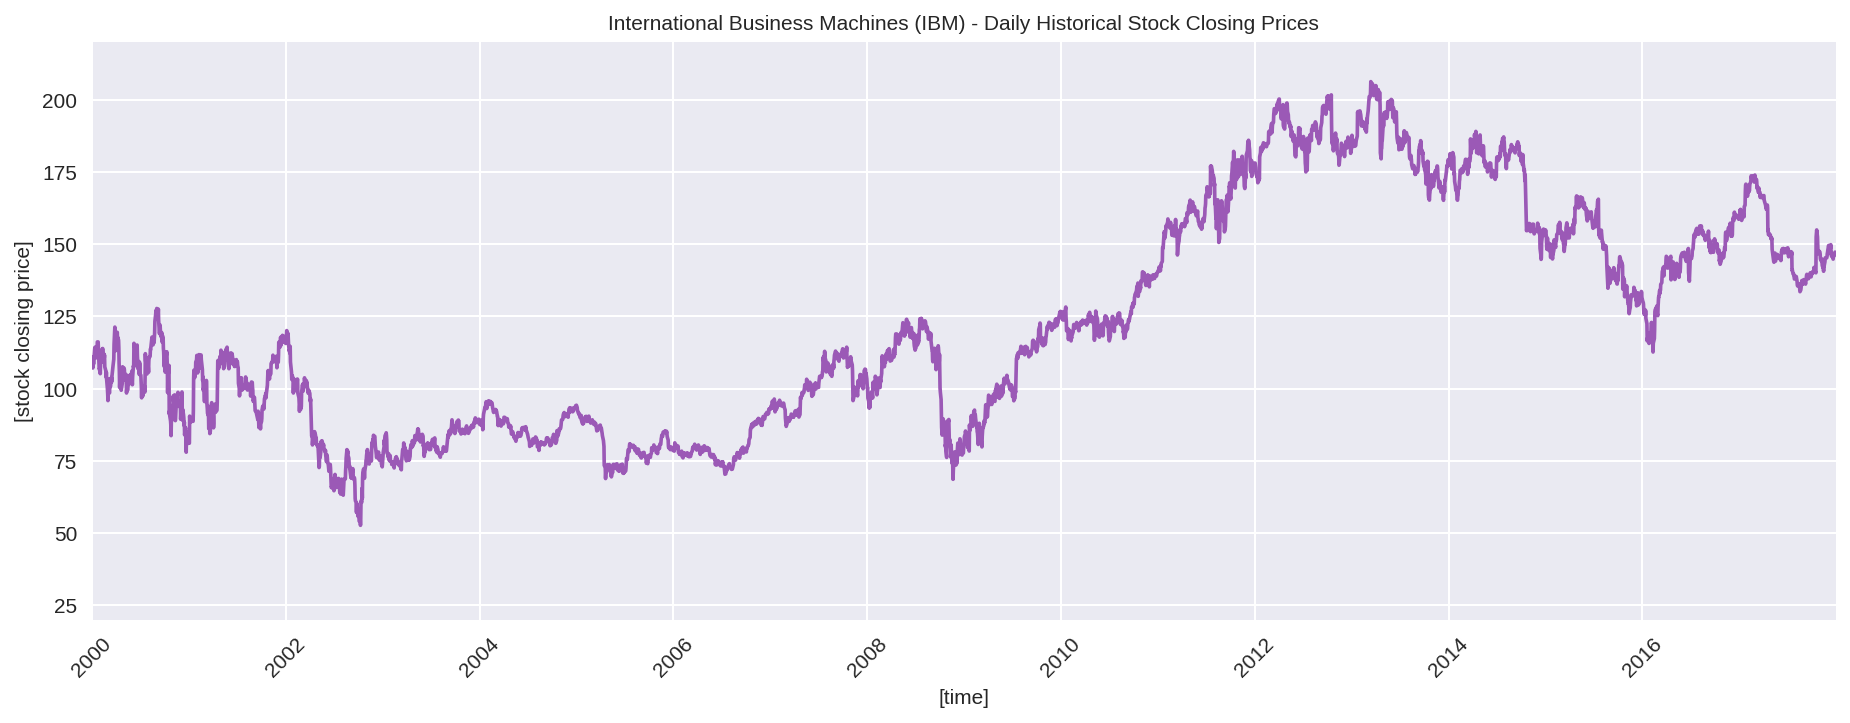

In [14]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot daily closing prices
ax.plot(stock_data.index, stock_data['Close'], color='#9b59b6')

# rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set x-axis labels and limits
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([pd.to_datetime('01-01-2000'), pd.to_datetime('31-12-2017')])

# set y-axis labels and limits
ax.set_ylabel('[stock closing price]', fontsize=10)
ax.set_ylim(20, 220)

# set plot title
plt.title('International Business Machines (IBM) - Daily Historical Stock Closing Prices', fontsize=10);

In [15]:
# save retrieved data to local data directory
stock_data.to_csv(os.path.join(data_directory,'ibm_data_2010_2017_daily.csv'), sep=';', encoding='utf-8')

## a. preprocessing

In this section, we will obtain daily returns of the retrieved daily closing prices. Also, we will convert the time-series of daily returns into a set of sequences $s$ of $n$ time steps respectively. The created sequences will then be used to learn a model using an Long Short-Term Memory neural network.

Let's always forward propagate the last valid available price information observation to the next available valid price information using the Panda's `reindex()` function. This in order to also obtain market price information of weekend's and holidays:

In [16]:
# fill weekends and holidays
stock_data = stock_data.reindex(index=pd.date_range(stock_data.index.min(), stock_data.index.max()), method='ffill')

In [17]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
2000-01-03,107.492828,110.898659,106.955070,110.898659,60.474819,10823694
2000-01-04,108.986618,109.464630,105.999046,107.134323,58.422092,8606279
2000-01-05,107.970840,114.483749,107.194077,110.898659,60.474819,13318927
2000-01-06,112.810707,113.706978,108.508606,108.986618,59.432117,8338607
2000-01-07,112.093689,112.750954,105.760040,108.508606,59.171490,12402108


In [18]:
stock_data.shape

(6571, 6)

## b. daily returns calculation

Determine the daily returns of the "International Business Machines" (IBM) daily closing prices using the Panda's `pct_change()` function:

In [19]:
stock_data['RETURN'] = stock_data['Close'].pct_change()

In [24]:
stock_data['RETURN']

2000-01-03         NaN
2000-01-04   -0.033944
2000-01-05    0.035137
2000-01-06   -0.017241
2000-01-07   -0.004386
                ...   
2017-12-25    0.000000
2017-12-26    0.002164
2017-12-27    0.001963
2017-12-28    0.005943
2017-12-29   -0.004025
Freq: D, Name: RETURN, Length: 6571, dtype: float64

In [25]:
#Remove the first row corresponding to a `nan` daily return of the stock data dataframe
stock_data = stock_data.iloc[1:]

Visually inspect the obtained daily returns:

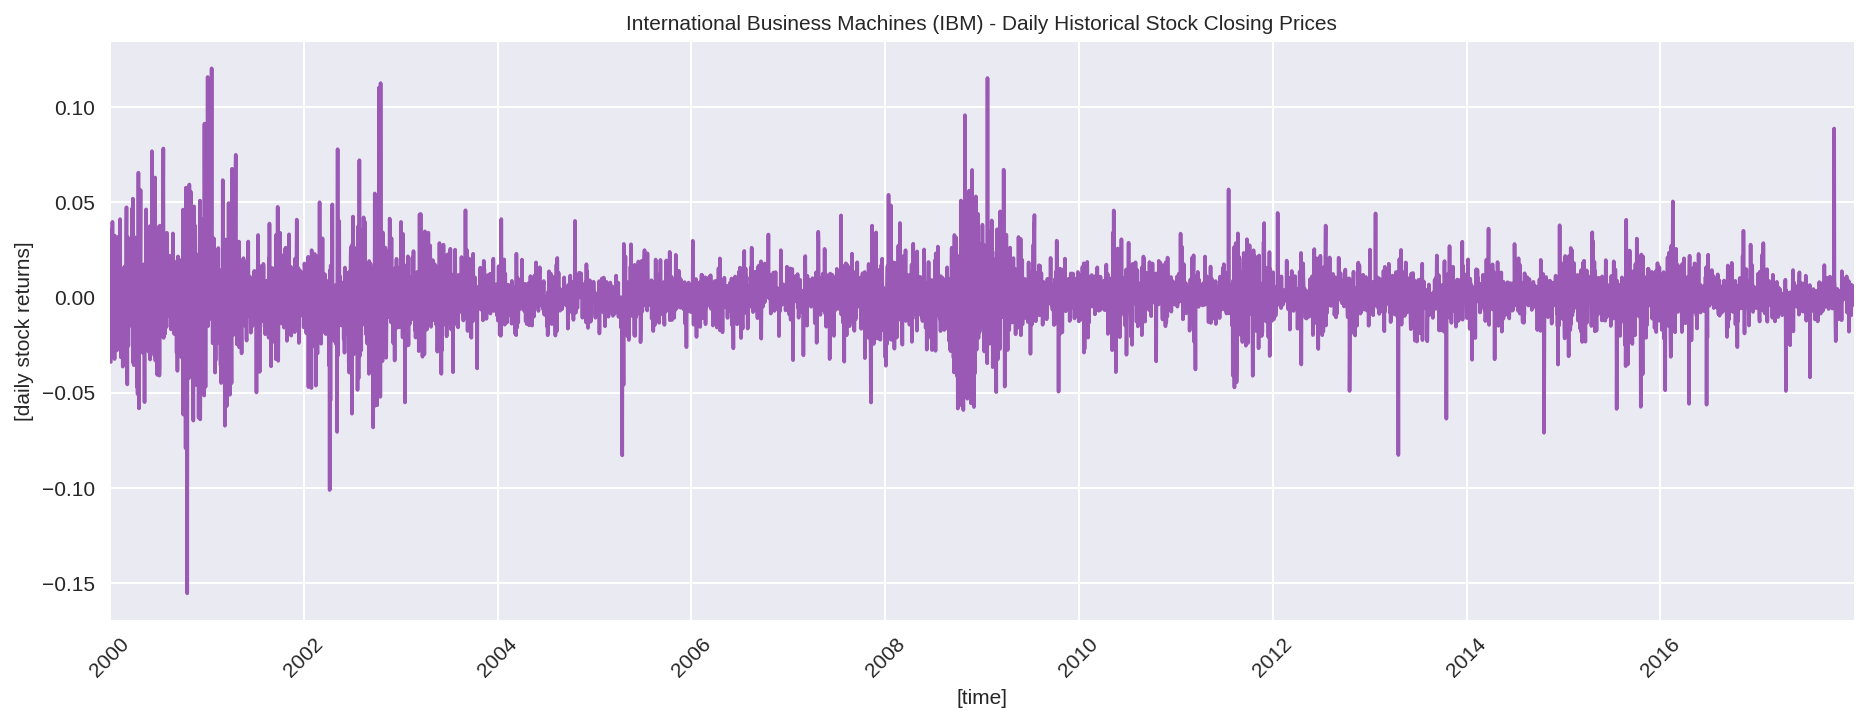

In [28]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot daily returns
ax.plot(stock_data.index, stock_data['RETURN'], color='#9b59b6')

# rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels and limits
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([pd.to_datetime('01-01-2000'), pd.to_datetime('31-12-2017')])
ax.set_ylabel('[daily stock returns]', fontsize=10)

# set plot title
plt.title('International Business Machines (IBM) - Daily Historical Stock Closing Prices', fontsize=10);

## c. data split

We set the split fraction of training sequences to **90%** of the total number of obtained sequences:

In [29]:
split_fraction = 0.9
split_row = int(stock_data.shape[0] * split_fraction)

Split obtained returns into training ("in-sample") returns $r^{i}_{train}$ and validation ("out-of-sample") returns $r^{i}_{valid}$:

In [30]:
train_stock_data = stock_data.iloc[:split_row]
valid_stock_data = stock_data.iloc[split_row:]

Visually inspect the obtained train and validation stock returns:

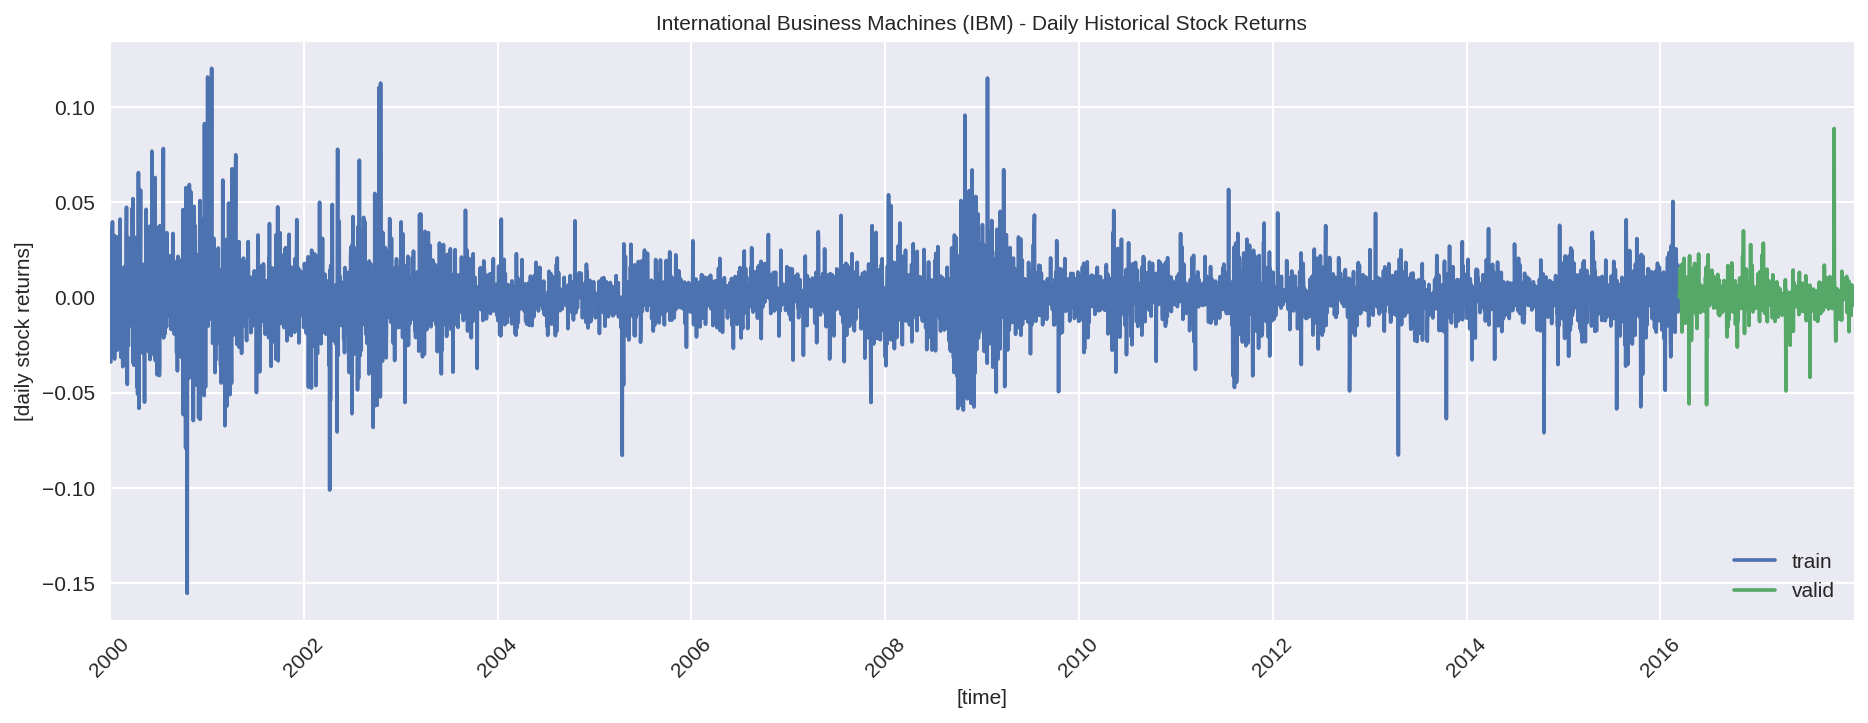

In [31]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot daily stock returns
ax.plot(stock_data.index[:split_row,], train_stock_data['RETURN'], c='C0', label='train')
ax.plot(stock_data.index[split_row:,], valid_stock_data['RETURN'], c='C1', label='valid')

# rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels and limits
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([pd.to_datetime('01-01-2000'), pd.to_datetime('31-12-2017')])
ax.set_ylabel('[daily stock returns]', fontsize=10)

# set plot legend
plt.legend(loc="lower right", numpoints=1, fancybox=True)

# set plot title
plt.title('International Business Machines (IBM) - Daily Historical Stock Returns', fontsize=10);

## d. sequence transformation

In the following, we determine the number of return time-steps $n$ each individual sequence $s^{i}$ should be comprised of. Each sequence is thereby determined by the number of predictor (return) time-steps $t$ and the prediction (return) horizon $h = t+1$.

In this example, we will set the number of predictor (return) time-steps to $t$=4. This indicates that the input sequence of each sample is a vector of 4 sequential daily stock returns (pls. note, the choice of $t$=4 is arbitrary and should be selected through experimentation). Furthermore, we set the predicted return horizon to 1, which specifies that we aim to forecast a single future time-step.

In [32]:
time_steps = 4 # number of predictor timesteps
horizon = 1 # number of timesteps to be predicted
sequence_length = time_steps + horizon # determine sequence length

Next, we extract the sequences $s^i$ of 5 time-steps.

Thereby, we will step-wise iterate ("rolling window") over the entire sequence of daily stock returns $r_i$. In each iteration step, we extract an individual sequence of stock returns consisting of $n$ time-steps. The extracted individual sequences of daily closing prices are then collected in a single data frame.

Next, we will determine the number of available **rolling training ("in-sample") target sequences**. Remember that each sequence exhibits consists of **a sequence length of 5 time-steps** as defined by the variable `sequence_length` above:

In [33]:
no_train_sequences = ((train_stock_data.shape[0] // sequence_length) - 1) * sequence_length

Let's now print the number of available rolling training sequences comprised of 5 daily return time-steps each:

In [34]:
no_train_sequences

5905

Initialize a 2D tensor (a 2D array) that contains the individual sequences from which we aim from to learn as part of the training procedure. The training data corresponds to a 2D tensor of size **`no_train_sequences`*`sequence_length`**. The tensor contains the daily returns of the IBM market price data:

In [35]:
# init the train sequence target daily returns data 2D matrix
train_stock_sequence_data = np.zeros([no_train_sequences, sequence_length])

# init the train sequence target daily dates data 2D matrix
train_stock_sequence_data_date = np.empty([no_train_sequences, sequence_length], dtype='datetime64[s]')

Let's now fill the created 2D tensor with the rolling sequences of the IBM's daily returns:

In [38]:
# iterate over the distinct daily returns of the training dataset
for i in range(0, no_train_sequences):

    # determine current training sequence returns
    return_sequence = np.array(train_stock_data['RETURN'][i:i + sequence_length].T)

    # determine current training sequence dates
    date_sequence = np.array(train_stock_data.index[i:i + sequence_length].T)

    # fill 2D matrix of train stock target sequences with current sequence
    train_stock_sequence_data[i, :] = return_sequence

    # fill 2D matrix of train stock target sequences with current sequence
    train_stock_sequence_data_date[i, :] = date_sequence

In [39]:
train_stock_sequence_data.shape

(5905, 5)

Also, inspect the **first 10 sequences** :

In [40]:
train_stock_sequence_data[0:10,]

array([[-0.03394392,  0.0351366 , -0.01724133, -0.00438597,  0.        ],
       [ 0.0351366 , -0.01724133, -0.00438597,  0.        ,  0.        ],
       [-0.01724133, -0.00438597,  0.        ,  0.        ,  0.03964756],
       [-0.00438597,  0.        ,  0.        ,  0.03964756,  0.00847459],
       [ 0.        ,  0.        ,  0.03964756,  0.00847459,  0.00420169],
       [ 0.        ,  0.03964756,  0.00847459,  0.00420169, -0.01046026],
       [ 0.03964756,  0.00847459,  0.00420169, -0.01046026,  0.01162789],
       [ 0.00847459,  0.00420169, -0.01046026,  0.01162789,  0.        ],
       [ 0.00420169, -0.01046026,  0.01162789,  0.        ,  0.        ],
       [-0.01046026,  0.01162789,  0.        ,  0.        ,  0.        ]])

Next, we will determine the number of available **rolling validation ("out-of-sample") target sequences**.

In [44]:
no_valid_sequences = ((valid_stock_data.shape[0] // sequence_length) - 1) * sequence_length

no_valid_sequences

650

In [45]:
# init the valid sequence target daily returns data 2D matrix
valid_stock_sequence_data = np.zeros([no_valid_sequences, sequence_length])

# init the valid sequence target daily dates data 2D matrix
valid_stock_sequence_data_date = np.empty([no_valid_sequences, sequence_length], dtype='datetime64[s]')

# iterate over the distinct daily returns of the validation dataset
for i in range(0, no_valid_sequences):

    # determine current validation sequence returns
    return_sequence = np.array(valid_stock_data['RETURN'][i:i + sequence_length].T)

    # determine current validation sequence dates
    date_sequence = np.array(valid_stock_data.index[i:i + sequence_length].T)

    # fill 2D matrix of valid stock target sequences with current sequence
    valid_stock_sequence_data[i, :] = return_sequence

    # fill 2D matrix of valid stock target sequences with current sequence
    valid_stock_sequence_data_date[i, :] = date_sequence

In [46]:
valid_stock_sequence_data.shape

(650, 5)

Also, inspect the **first 10 sequences**:

In [47]:
valid_stock_sequence_data[0:10,]

array([[ 0.        ,  0.00295031,  0.0012606 ,  0.01280082,  0.01553971],
       [ 0.00295031,  0.0012606 ,  0.01280082,  0.01553971,  0.00034008],
       [ 0.0012606 ,  0.01280082,  0.01553971,  0.00034008,  0.        ],
       [ 0.01280082,  0.01553971,  0.00034008,  0.        ,  0.        ],
       [ 0.01553971,  0.00034008,  0.        ,  0.        ,  0.01046978],
       [ 0.00034008,  0.        ,  0.        ,  0.01046978, -0.00356584],
       [ 0.        ,  0.        ,  0.01046978, -0.00356584, -0.01823097],
       [ 0.        ,  0.01046978, -0.00356584, -0.01823097,  0.01753777],
       [ 0.01046978, -0.00356584, -0.01823097,  0.01753777,  0.        ],
       [-0.00356584, -0.01823097,  0.01753777,  0.        ,  0.        ]])

#### 2.4 Conduct Input-Target Split for Neural Network Training

Before we continue the data pre-processing, let's briefly revisit how RNN's or, more specifically, LSTM based NN's can be trained to predict the next element of an input sequence.

For each **input return** $r_{i}$ of the input return training sequence $s^i$, the LSTM is supposed to learn to **predict the return** of the next time-step $\hat{r}_{i+1}$. In order to make such a future return $\hat{r}_{i+1}$ prediction the LSTM uses it's learned hidden state information $h_{i}$ as well as the current return $r_{i}$ as an input.

For each time-step the predicted return $\hat{r}_{i+1}$ is then compared to the **target return** $r_{i+1}$. The discrepancy between both is collected as a loss $\mathcal{L}$ for the distinct timesteps. The accumulation of the individual time-step losses is accumulated as the total loss of a sequence $\mathcal{L}_{All}$

Let's eperate each training sequence $s^{i}$ into time-steps of input returns denoted by $s^{i}_{train, input}=\{r_{t-n-1}, ..., r_{t-1}, r_{t}\}$ and the time-step of the to be predicted target return denoted by $s^{i}_{train, target}=r_{t+1}$.

In addition, we convert both the input returns as well as the target returns to PyTorch tensors:

In [48]:
train_sequences_input = torch.from_numpy(train_stock_sequence_data[:, :-1]).float()
train_sequences_target = torch.from_numpy(train_stock_sequence_data[:, 1:]).float()

Seperate each validation sequence $s^{i}$ into time-steps of input returns denoted by $s^{i}_{valid, input}=\{r_{t-n-1}, ..., r_{t-1}, r_{t}\}$ and the time-step of the to be predicted target return denoted by $s^{i}_{valid, target}=r_{t+1}$. In addition, we convert both the input returns as well as the target returns to PyTorch tensors:

In [49]:
valid_sequences_input = torch.from_numpy(valid_stock_sequence_data[:, :-1]).float()
valid_sequences_target = torch.from_numpy(valid_stock_sequence_data[:, 1:]).float()

To train an LSTM neural network, we tailor the dataset class provided by the PyTorch library. We overwrite the individual functions of the dataset class. So that our dataset will supply the neural network with the individual training sequences $s^{i}_{train, input}$ and corresponding targets $s^{i}_{train, target}$ throughout the training process:

In [50]:
# define daily returns dataset
class DailyReturnsDataset(data.Dataset):

    # define the class constructor
    def __init__(self, sequences, targets):

        # init sequences and corresponding targets
        self.sequences = sequences
        self.targets = targets

    # define the length method
    def __len__(self):

        # returns the number of samples
        return len(self.targets)

    # define the get item method
    def __getitem__(self, index):

        # determine single sequence and corresponding target
        sequence = self.sequences[index, :]
        target = self.targets[index, :]

        # return sequences and target
        return sequence, target

Once we have specified the daily returns dataset class we instantiate it using the new daily closing dataset using the prepared training input sequences $s^{i}_{train, input}$ and corresponding targets $s^{i}_{train, target}$:

In [51]:
train_dataset = DailyReturnsDataset(train_sequences_input, train_sequences_target)

Let's see how it works by getting the 42th sequence and its corresponding targets:

In [52]:
train_dataset.__getitem__(42)

(tensor([ 0.0092, -0.0117,  0.0086, -0.0364]),
 tensor([-0.0117,  0.0086, -0.0364,  0.0000]))

# 2. NEURAL NETWORK IMPLEMENTATION

## a. architecture

In this section, we will implement the architecture of the LSTM neural network utilized to predict future returns of financial time series data, e.g. as in this example, the future returns of a given stock. The neural network, which we name **'LSTMNet'** consists in total of three layers. The first two layers correspond to LSTM cells, while the third layer corresponds to a fully-connected linear layer.

Each LSTM layer consits of a LSTM cell exhibiting a hidden state of 51 dimensions. The third linear squeezes the 51 hidden state dimensions of the second LSTM cell into a single output dimension. The single output signal of the linear layer refers to the return of the next time-step predicted by the neural network. Please note, that the choice of the implemented architecture and network hyperparameters is arbitrary and should in a real-world scenario be evaluated and selected thoroughly through experimentation.

In [54]:
# implement the LSTMNet network architecture
class LSTMNet(nn.Module):

    # define class constructor
    def __init__(self):

        super(LSTMNet, self).__init__()

        # define the lstm nn architecture

        # the first lstm layer
        self.lstm1 = nn.LSTMCell(1, 51)

        # the second lstm layer
        self.lstm2 = nn.LSTMCell(51, 51)

        # the final linear layer
        self.linear = nn.Linear(51, 1)

    # define network forward pass
    def forward(self, input):

        # init predictions
        predictions = []

        # init the lstm hidden states
        h_t1 = torch.zeros(input.size(0), 51, dtype=torch.float).to(device)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.float).to(device)

        # init the lstm cell states
        c_t1 = torch.zeros(input.size(0), 51, dtype=torch.float).to(device)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.float).to(device)

        # iterate over distinct time steps
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):

            # propagate through the first lstm layer
            h_t1, c_t1 = self.lstm1(input_t, (h_t1, c_t1))

            # propagate through the second lstm layer
            h_t2, c_t2 = self.lstm2(h_t1, (h_t2, c_t2))

            # propagate through the final linear layer
            prediction = self.linear(h_t2)

            # collect predictions
            predictions += [prediction]

        # stack predictions
        predictions = torch.stack(predictions, 1).squeeze(2)

        # return predictions
        return predictions

Now, that we have implemented our first LSTM neural network we are ready to instantiate a model to be trained:

In [55]:
lstm_model = LSTMNet().to(device)

In [56]:
# print the initialized architectures
print('LSTMNet architecture:\n\n{}\n'.format(lstm_model))

LSTMNet architecture:

LSTMNet(
  (lstm1): LSTMCell(1, 51)
  (lstm2): LSTMCell(51, 51)
  (linear): Linear(in_features=51, out_features=1, bias=True)
)



Looks like intended? Great! Finally, let's have a look into the number of model parameters that we aim to train in the next steps of the notebook:

In [58]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in lstm_model.parameters():

    # collect number of parameters
    num_params += param.numel()

# print the number of model paramters
print('Number of to be trained LSTMNet model parameters: {}.'.format(num_params))

Number of to be trained LSTMNet model parameters: 32284.


## b. loss function

We are now good to train the network. However, prior to starting the training, we need to define an appropriate loss function. Remember, we aim to train our model to learn a set of model parameters $\theta$ that minimize the prediction error of the true return $r_{t+1}$ and the by the model predicted return $\hat{r}_{t+1}$ at a given time-step $t+1$ of sequence $s^{i}$. In other words, for a given sequence of historic returns we aim to learn a function $f_\theta$ that is capable to predicts the return of the next timestep as faithfully as possible, as expressed by:

<center> $\hat{r}_{t+1} = f_\theta(r_{t}, r_{t-1}, ..., r_{t-n})$. </center>

Thereby, the training objective is to learn a set of optimal model parameters $\theta^*$ that optimize $\min_{\theta} \|r_{t+1} - f_\theta(r_{t}, r_{t-1}, ..., r_{t-n})\|$ over all time-steps $t$ contained in the set of training sequences $s_{train}$. To achieve this optimization objective, one typically minimizes a loss function $\mathcal{L_{\theta}}$ while training the neural network. In this lab we use the **'Mean Squared Error (MSE)'** loss, as denoted by:

<center> $\mathcal{L}^{MSE}_{\theta} (r_{t+1}, \hat{r}_{t+1}) = \frac{1}{N} \sum_{i=1}^N \| r_{t+1} - \hat{r}_{t+1}\|^{2}$, </center>

In [59]:
loss_function = nn.MSELoss(reduction='mean').to(device)

Throughout the training process, the PyTorch library will automatically calculate the loss magnitude, compute the gradient, and update the parameters $\theta$ of the LSTM neural network. We will use the **"Adaptive Moment Estimation Optimization" (ADAM)** technique to optimize the network parameters. Furthermore, we specify a constant learning rate of $l = 1e-06$. For each training step, the optimizer will update the model parameters $\theta$ values according to the degree of prediction error (the MSE loss).

In [60]:
learning_rate = 1e-06 # set constant learning rate
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate) # define optimization technique

## c. training

Let's now start to learn a model by training the NN for **100 epochs** in mini-batches of the size of **128  sequences** per batch. This implies that the whole dataset will be fed to the network **100 times** in chunks of 128 sequences yielding to **32 mini-batches** (4'068 training sequences / 128 sequences per mini-batch) per epoch:

In [66]:
# specify the training parameters
num_epochs = 100 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

Furthermore, lets specify and instantiate a corresponding `PyTorch` data loader that feeds the tensors to our neural network:

In [67]:
train_dataloader = dataloader.DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)

#### 4.2. Running the Network Training

Finally, we start training the model. The training procedure of each mini-batch is performed as follows:

>1. do a forward pass through the LSTMNet network,
>2. compute the mean-squared prediction error $\mathcal{L}^{MSE}_{\theta} (r_{t+1}, \hat{r}_{t+1}) = \frac{1}{N} \sum_{i=1}^N \| r_{t+1} - \hat{r}_{t+1}\|^{2}$,
>3. do a backward pass through the LSTMNet network, and
>4. update the parameters of the network $f_\theta(\cdot)$.

To ensure learning while training the LSTM model we will monitor whether the loss decreases with progressing training. Therefore, we obtain and evaluate the mean prediction performance over all mini-batches in each training epoch. Based on this evaluation we can conclude on the training progress and whether the loss is converging (indicating that the model might not improve any further).

The following elements of the network training code below should be given particular attention:

>- `loss.backward()` computes the gradients based on the magnitude of the mean-squared-loss,
>- `optimizer.step()` updates the network parameters based on the gradient.

In [ ]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
lstm_model.train()

# init the best loss
best_loss = 100.00

# iterate over epochs
for epoch in range(0, num_epochs):

    # init collection of mini-batch losses
    train_mini_batch_losses = []

    # iterate over mini-batches
    for sequence_batch, target_batch in train_dataloader:

        # push mini-batch data to computation device
        sequence_batch = sequence_batch.to(device)
        target_batch = target_batch.to(device)

        # predict sequence output
        prediction_batch = lstm_model(sequence_batch)

        # calculate batch loss
        batch_loss = loss_function(prediction_batch, target_batch)

        # run backward gradient calculation
        batch_loss.backward()

        # update network parameters
        optimizer.step()

        # collect mini-batch loss
        train_mini_batch_losses.append(batch_loss.data.item())

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)

    # print epoch loss
    now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))

    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

    # print epoch and save models
    if epoch % 10 == 0 and epoch > 0:

        # case: new best model trained
        if train_epoch_loss < best_loss:

            # store new best model
            model_name = 'best_lstm_model_{}.pth'.format(str(epoch))
            torch.save(lstm_model.state_dict(), os.path.join(models_directory, model_name))

            # update best loss
            best_loss = train_epoch_loss

            # print epoch loss
            now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            print('[LOG {}] epoch: {} new best train-loss: {} found'.format(str(now), str(epoch), str(train_epoch_loss)))

Upon successful training let's visualize and inspect the training loss per epoch:

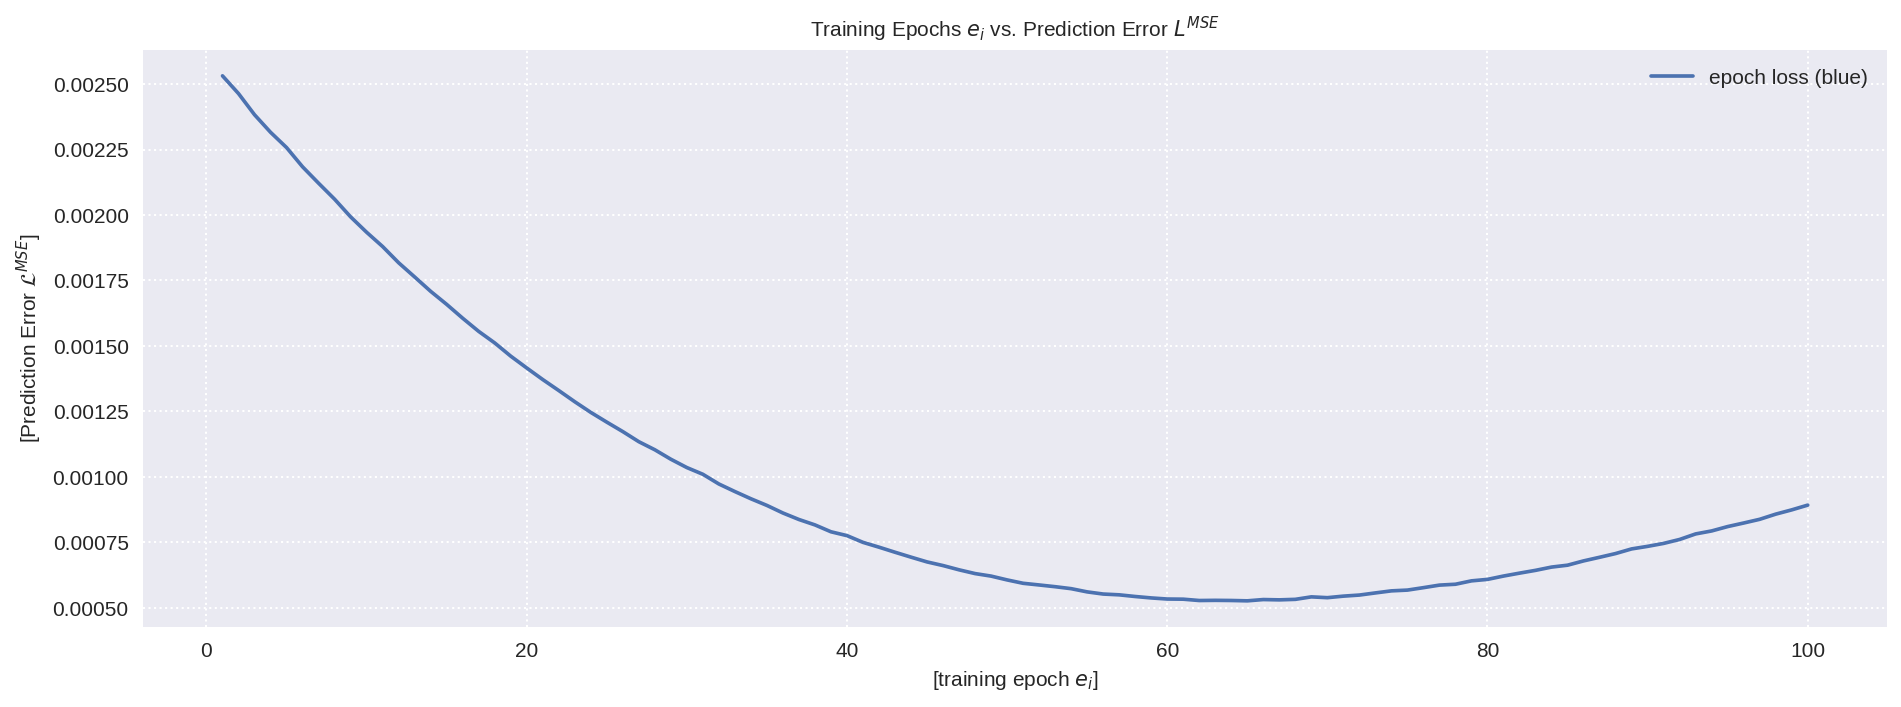

In [69]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' prediction error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Prediction Error $\mathcal{L}^{MSE}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Prediction Error $L^{MSE}$', fontsize=10);

## d. evaluation

In this section, we will conduct a visual comparison of the predicted daily returns to the actual ('true') daily returns. The comparison will encompass the daily returns of the in-sample time period as well as the returns of the out-of-sample time period.

### i. in-sample

Before starting our evaluation, let's load the best performing model or an already pre-trained model (as done below). Remember, that we stored a snapshot of the model after each training epoch to our local model directory. We will now load one of the (hopefully well-performing) snapshots saved.

In [70]:
# init the pre-trained model architecture
lstm_model_pretrained = LSTMNet().to(device)

# set the pre-trained model name we aim to load
lstm_model_name_pretrained = 'https://raw.githubusercontent.com/financial-data-science/CFDS-Notebooks/master/lab_14/models/best_lstm_model_30000.pth'

# read pretrained model from the remote location
lstm_model_bytes = urllib.request.urlopen(lstm_model_name_pretrained)

# load tensor from io.BytesIO object
lstm_model_buffer = io.BytesIO(lstm_model_bytes.read())

# load the pre-trained model paramaters
lstm_model_pretrained.load_state_dict(torch.load(lstm_model_buffer, map_location=lambda storage, loc: storage))

<All keys matched successfully>

In [71]:
# set model in evaluation mode
lstm_model_pretrained.eval()

LSTMNet(
  (lstm1): LSTMCell(1, 51)
  (lstm2): LSTMCell(51, 51)
  (linear): Linear(in_features=51, out_features=1, bias=True)
)

Use the pre-trained model to determine the daily return predictions of the **in-sample** sequence population:

In [72]:
# don't calculate gradients
with torch.no_grad():

    # predict sequence output
    train_predictions = lstm_model_pretrained(train_sequences_input.to(device))

    # collect prediction batch results
    train_predictions_list = train_predictions.cpu().detach().numpy()[:, -1].tolist()

    # collect target batch results
    train_targets_list = train_sequences_target.numpy()[:, -1].tolist()

Plot the pre-trained `LSTMNet` daily **in-sample** predictions vs. the target ("ground-truth") daily returns:

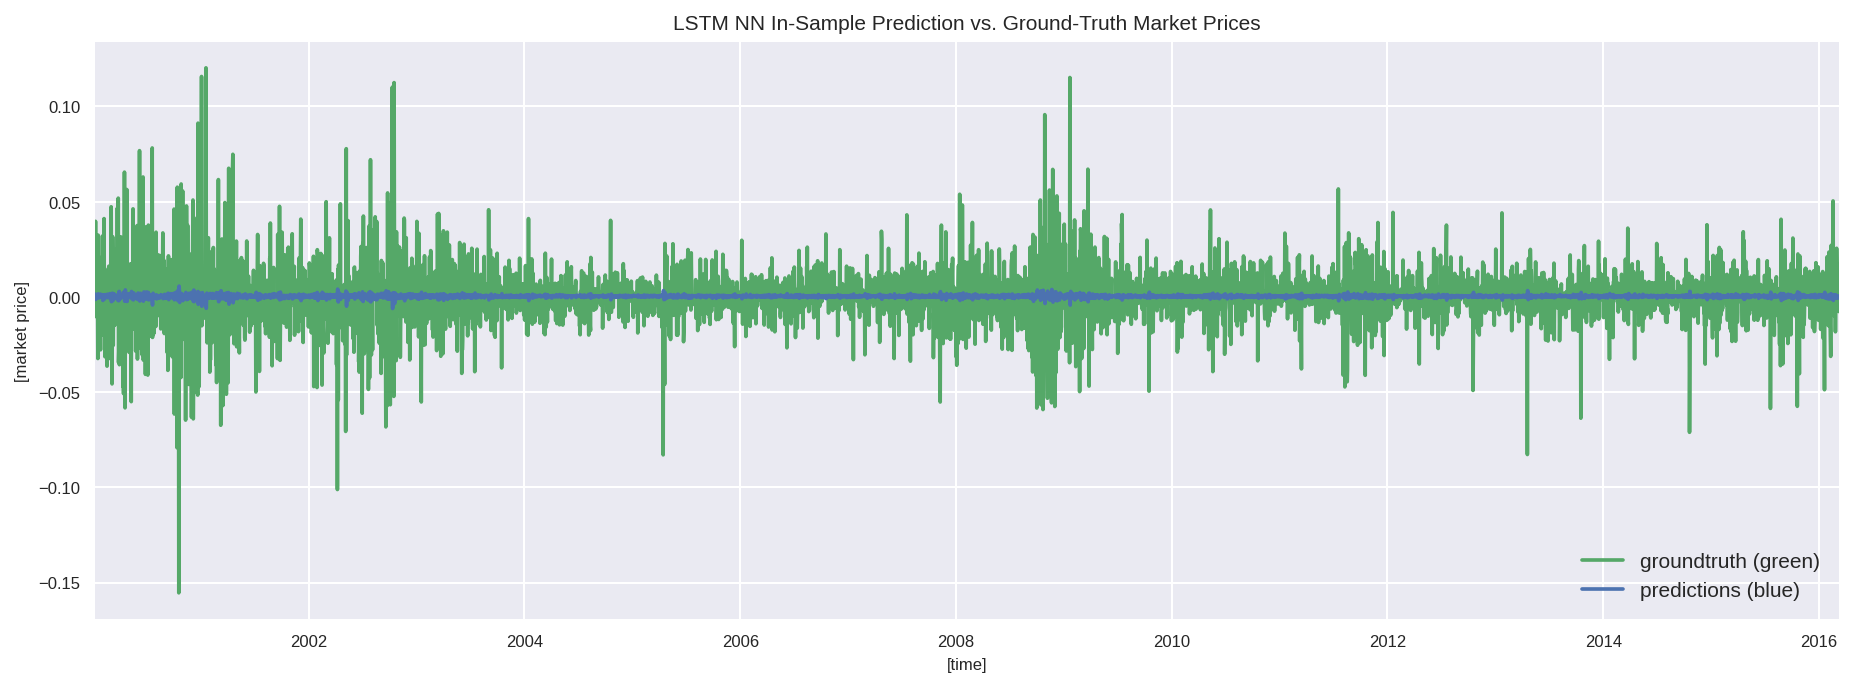

In [73]:
# plot the prediction results
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 5]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(train_stock_sequence_data_date[:, -1], train_targets_list, color='C1', label='groundtruth (green)')
ax.plot(train_stock_sequence_data_date[:, -1], train_predictions_list, color='C0', label='predictions (blue)')

# set y-axis limits
ax.set_xlim(train_stock_sequence_data_date[:, -1].min(), train_stock_sequence_data_date[:, -1].max())

# set plot legend
plt.legend(loc="lower right", numpoints=1, fancybox=True)

# set plot title
plt.title('LSTM NN In-Sample Prediction vs. Ground-Truth Market Prices', fontsize=10)

# set axis labels
plt.xlabel('[time]', fontsize=8)
plt.ylabel('[market price]', fontsize=8)

# set axis ticks fontsize
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);

### ii. out-of-sample

Use the pre-trained model to determine the daily return predictions of the **out-of-sample** sequence population:

In [74]:
# don't calculate gradients
with torch.no_grad():

    # predict sequence output
    valid_predictions = lstm_model_pretrained(valid_sequences_input.to(device))

    # collect prediction batch results
    valid_predictions_list = valid_predictions.cpu().detach().numpy()[:, -1].tolist()

    # collect target batch results
    valid_targets_list = valid_sequences_target.numpy()[:, -1].tolist()

Plot the pre-trained `LSTMNet` daily **out-of-sample** predictions vs. the target ("ground-truth") daily returns:

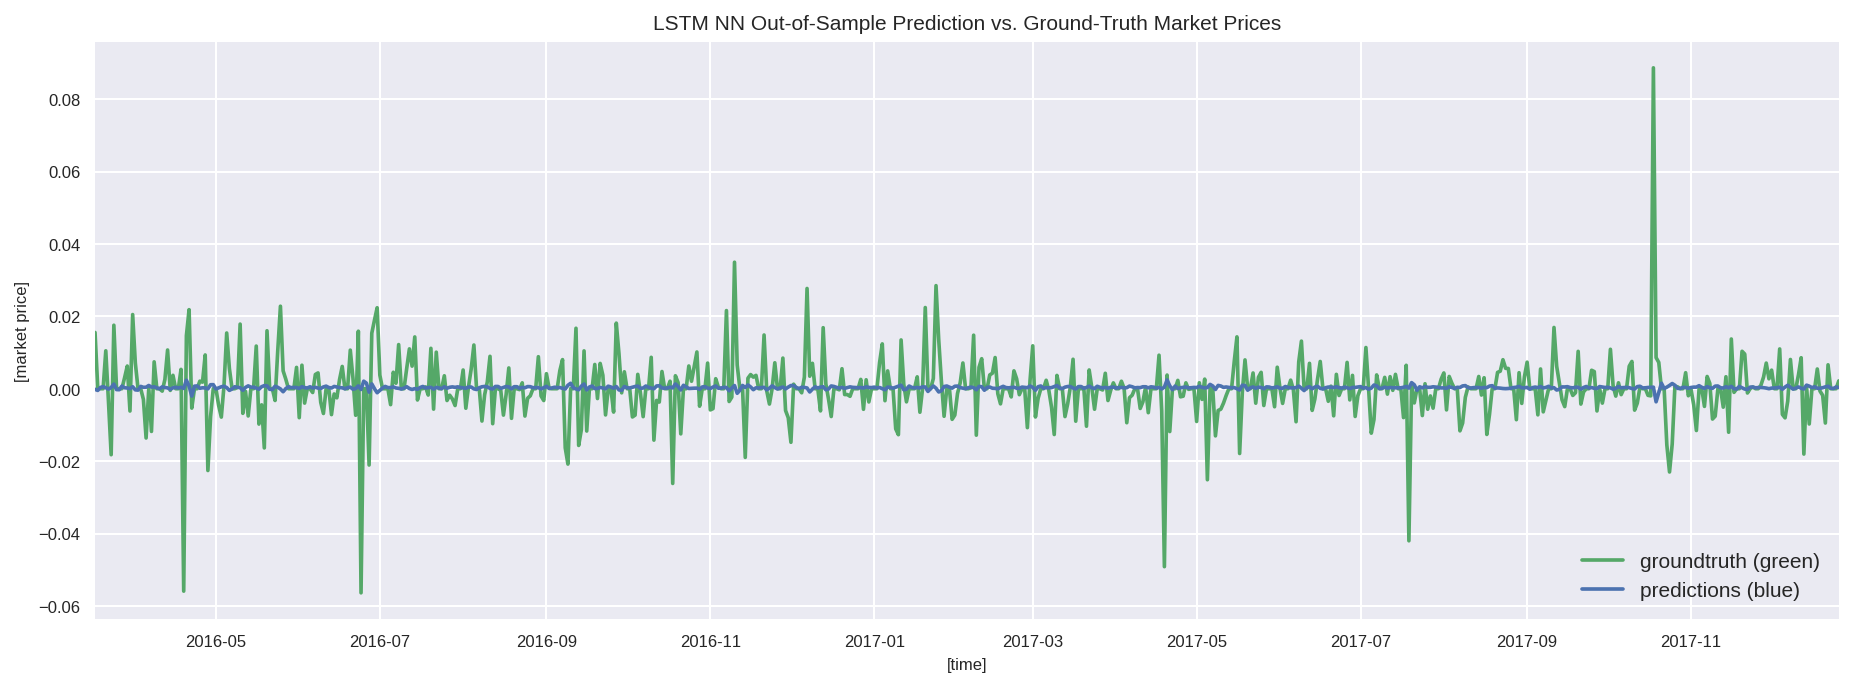

In [75]:
# plot the prediction results
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 5]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(valid_stock_sequence_data_date[:, -1], valid_targets_list, color='C1', label='groundtruth (green)')
ax.plot(valid_stock_sequence_data_date[:, -1], valid_predictions_list, color='C0', label='predictions (blue)')

# set y-axis limits
ax.set_xlim(valid_stock_sequence_data_date[:, -1].min(), valid_stock_sequence_data_date[:, -1].max())

# set plot legend
plt.legend(loc="lower right", numpoints=1, fancybox=True)

# set plot title
plt.title('LSTM NN Out-of-Sample Prediction vs. Ground-Truth Market Prices', fontsize=10)

# set axis labels
plt.xlabel('[time]', fontsize=8)
plt.ylabel('[market price]', fontsize=8)

# set axis ticks fontsize
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);

# 3. BACKTESTING

In this section, we will backtest the python `bt` library. Python `bt` is a flexible, backtest framework that can be used to test quantitative trading strategies. In general, backtesting is the process of testing a strategy over a given data set.

In order to test the predictions derived from the LSTM model we will view its predictions $\hat{r}_{i+1}$ as trade signals $\phi$. Thereby, we will interpret any positive future return prediction $r_{t+1} > 0.0$ of a sequence $s^i$ as a "long" (buy) signal. Likewise, we will interpret any negative future return prediction $r_{t+1} < 0.0$ of a sequence $s$ as a "short" (sell) signal.

## a. signal preparation

Let's start by converting the out-of-sample model predictions into a trading signal, as described above. Therefore, we first convert the obtained predictions into a data frame that contains (1) the **date of the predicted returns** as well as (2) the **predicted returns $r_{t+1}$** itself:

In [76]:
signal_data = pd.DataFrame(valid_predictions_list, columns=['PREDICTIONS'], index=valid_stock_sequence_data_date[:, -1])

In [77]:
signal_data.head()

,PREDICTIONS
2016-03-17,-0.000161
2016-03-18,-0.000474
2016-03-19,0.000342
2016-03-20,0.000569
2016-03-21,0.000268


Now, let's derive a trading signal from the converted predictions. As already described, we will generate the trading signal $\phi(\hat{r}_{t+1})$ according to the following function:

<center>
$
\\
\phi(\hat{r}_{t+1})=
\begin{cases}
1.0 & \textrm{("long signal")}, & for & \hat{r}_{t+1} > 0.0\\
-1.0 & \textrm{("short signal")}, & for & \hat{r}_{t+1} < 0.0\\
\end{cases}
$
</center>

where $\hat{r}_{t+1}$ denotes a by the model predicted future return at time $t+1$.

In [78]:
signal_data['SIGNAL'] = np.where(signal_data['PREDICTIONS'] > 0.0, 1.0, -1.0)

In [79]:
signal_data.head()

,PREDICTIONS,SIGNAL
2016-03-17,-0.000161,-1.0
2016-03-18,-0.000474,-1.0
2016-03-19,0.000342,1.0
2016-03-20,0.000569,1.0
2016-03-21,0.000268,1.0


Let's now offset the prepared trading signal by a single day $t-1$. Thereby, we rebalance our stock positions one day prior and according to the closing price predicted by the `LSTMNet` model. As a result we will be able to anticipate the model's future closing price prediction for a particular day $t$:

In [80]:
signal_data = signal_data.set_index(signal_data['SIGNAL'].index - pd.DateOffset(1))

Visualize the predicted and prepared trading signals of the `LSTMNet` model:

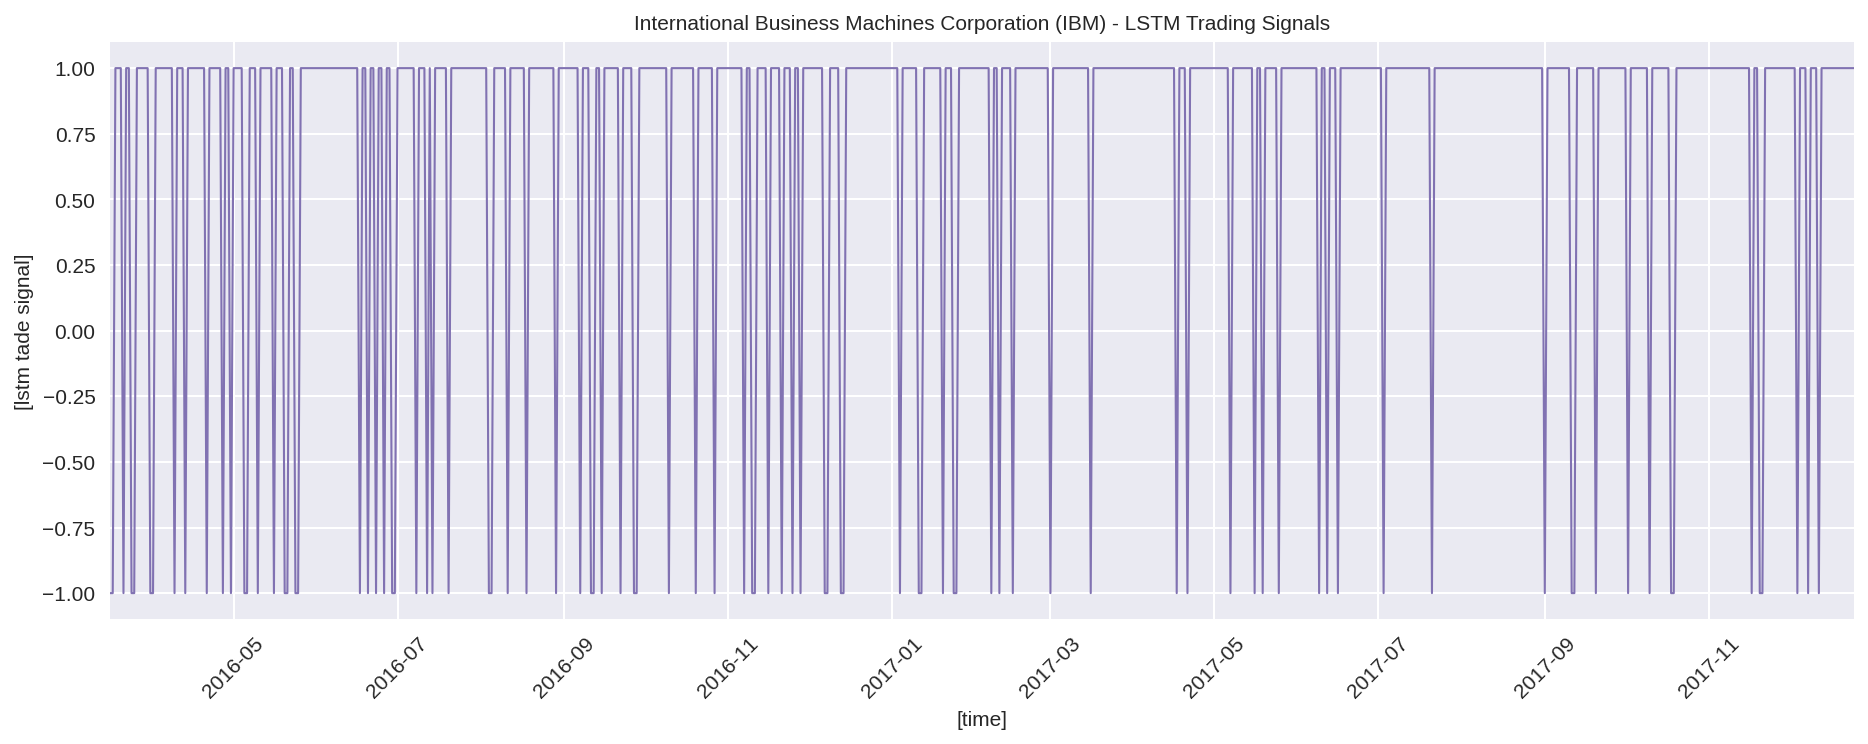

In [81]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(signal_data['SIGNAL'], lw=1.0, color='C3', label='LSTM trade signals')

# set axis ranges
ax.set_xlim([signal_data.index[0], signal_data.index[-1]])
ax.set_ylim([-1.1, 1.1])

# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_ylabel('[lstm tade signal]', fontsize=10)

# rotate x-axis ticks
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set plot title
ax.set_title('International Business Machines Corporation (IBM) - LSTM Trading Signals', fontsize=10);

Determine the number of trade signal changes (trades to be executed) within the out-of-sample timeframe **03/2016** until **12/2017**, resulting in a total in-sample timeframe of approx. **21 months** (9 + 12):

In [82]:
# determine number of signal changes
len(list(itertools.groupby(signal_data['SIGNAL'], lambda x: x > 0)))

148

On average around **7** signal changes (trades) per month (148 signal changes / 21 months) within the out-of-sample time period.

Now, let's prepare the daily closing prices so that they can be utilized in the backtest:

In [83]:
stock_market_data = pd.DataFrame(stock_data['Close'])
stock_market_data = stock_market_data.rename(columns={'Close': 'PRICE'})
stock_market_data = stock_market_data.set_index(pd.to_datetime(stock_data.index))

Let's inspect the top 5 rows of the prepared closing prices:

In [85]:
stock_market_data.head()

,PRICE
2000-01-04,107.134323
2000-01-05,110.898659
2000-01-06,108.986618
2000-01-07,108.508606
2000-01-08,108.508606


Sub-sample the prepared daily closing prices to the out-of-sample time period:

In [86]:
stock_market_data = stock_market_data[stock_market_data.index >= signal_data.index[0]]
stock_market_data = stock_market_data[stock_market_data.index <= signal_data.index[-1]]

In [87]:
stock_market_data.head()

,PRICE
2016-03-16,138.422562
2016-03-17,140.573608
2016-03-18,140.621414
2016-03-19,140.621414
2016-03-20,140.621414


Visualize the out-of-sample daily closing prices:

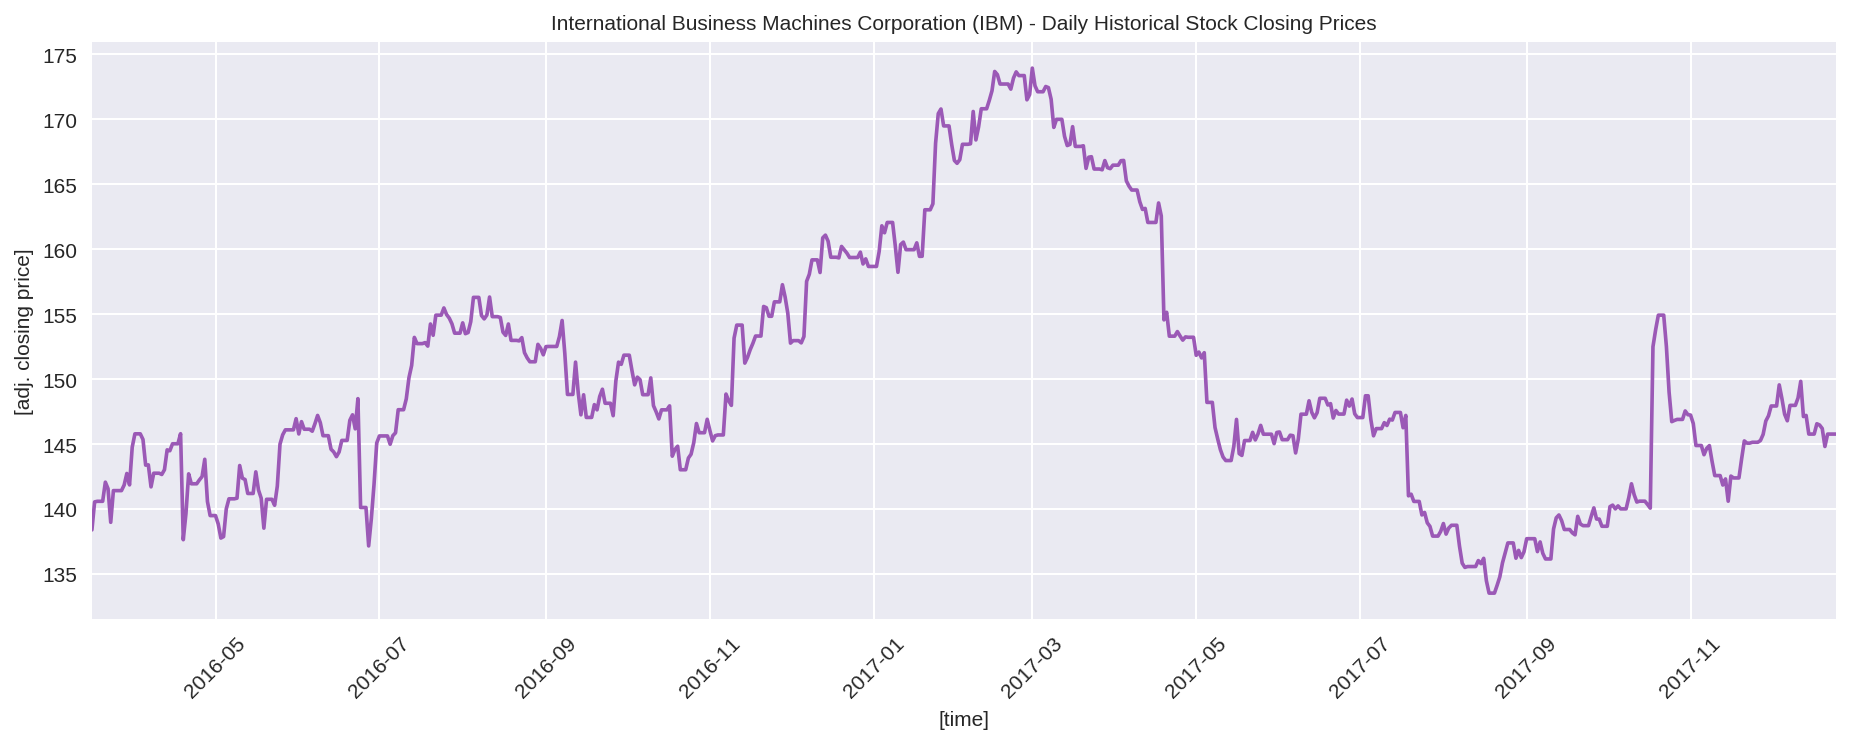

In [88]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(stock_market_data['PRICE'], color='#9b59b6')

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_ylabel('[equity %]', fontsize=10)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels and limits
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([stock_market_data.index[0], stock_market_data.index[-1]])
ax.set_ylabel('[adj. closing price]', fontsize=10)

# set plot title
plt.title('International Business Machines Corporation (IBM) - Daily Historical Stock Closing Prices', fontsize=10);

Let's calculate the potentially gained return by the application of a simple **"buy and hold"** strategy:

In [89]:
np.abs(stock_market_data.iloc[0]['PRICE'] - stock_market_data.iloc[-1]['PRICE']) / stock_market_data.iloc[0]['PRICE']

0.053249564770993976

Ok, with such a simple strategy we would have been able to yield a total return of approx. **5.32%**.

## b. backtest preparation

Now that we have trading signals as well as the market data let's implement the LSTM based trading strategy which we name `LSTMStrategy`:

In [90]:
class LSTMStrategy(bt.Algo):

    def __init__(self, signals):

        # set class signals
        self.signals = signals

    def __call__(self, target):

        if target.now in self.signals.index[1:]:

            # get actual signal
            signal = self.signals[target.now]

            # set target weights according to signal
            target.temp['weights'] = dict(PRICE=signal)

        # return True since we want to move on to the next timestep
        return True

Let's instantiate our LSTM based trading strategy:

In [91]:
lstm_strategy = bt.Strategy('lstm', [bt.algos.SelectAll(), LSTMStrategy(signal_data['SIGNAL']), bt.algos.Rebalance()])

Initialize the backtest of our LSTM based trading strategy using the strategy and prepared market data:

In [92]:
backtest_lstm = bt.Backtest(strategy=lstm_strategy, data=stock_market_data, name='stock_lstm_backtest')

In addition, let's also prepare a backtest of a "baseline" buy-and-hold trading strategy for comparison purposes. Our buy-and-hold strategy sends a "long" (+1.0) signal at each time step of the out-of-sample time frame:

In [93]:
signal_data_base = signal_data.copy(deep=True)
signal_data_base['SIGNAL'] = 1.0

Init the buy-and-hold ("base") strategy as well as the corresponding backtest:

In [94]:
base_strategy = bt.Strategy('base', [bt.algos.SelectAll(), LSTMStrategy(signal_data_base['SIGNAL']), bt.algos.Rebalance()])
backtest_base = bt.Backtest(strategy=base_strategy, data=stock_market_data, name='stock_base_backtest')

### backtest run

Run the backtest for both trading strategies:

In [95]:
backtest_results = bt.run(backtest_lstm, backtest_base)

Inspect the individual backtest results and performance measures:

In [96]:
backtest_results.display()

Stat                 stock_lstm_backtest    stock_base_backtest
-------------------  ---------------------  ---------------------
Start                2016-03-15             2016-03-15
End                  2017-12-25             2017-12-25
Risk-free rate       0.00%                  0.00%

Total Return         50.63%                 3.71%
Daily Sharpe         1.22                   0.17
Daily Sortino        2.10                   0.26
CAGR                 25.88%                 2.07%
Max Drawdown         -13.33%                -23.22%
Calmar Ratio         1.94                   0.09

MTD                  4.16%                  -0.95%
3m                   5.81%                  4.54%
6m                   -0.55%                 -1.04%
YTD                  5.94%                  -8.13%
1Y                   5.48%                  -8.52%
3Y (ann.)            -                      -
5Y (ann.)            -                      -
10Y (ann.)           -                      -
Since Incep. (ann

Collect detailed backtest performance per timestep of the LSTM trading strategy:

In [97]:
backtest_lstm_details = backtest_lstm.strategy.prices.to_frame(name='Rel. EQUITY')
backtest_lstm_details['Abs. EQUITY'] = backtest_lstm.strategy.values # equity per timestep
backtest_lstm_details['CASH'] = backtest_lstm.strategy.cash # cash per timestep
backtest_lstm_details['POSITIONS'] = backtest_lstm.strategy.positions # positions per timestep
backtest_lstm_details['FEES'] = backtest_lstm.strategy.fees # trading fees per timestep

Inspect the LSTM trading strategy backtest details:

In [98]:
backtest_lstm_details.head()

,Rel. EQUITY,Abs. EQUITY,CASH,POSITIONS,FEES
2016-03-15,100.000000,1000000.000000,1.000000e+06,0.0,0.0
2016-03-16,100.000000,1000000.000000,1.000000e+06,0.0,0.0
2016-03-17,100.000000,1000000.000000,2.000041e+06,-7114.0,0.0
2016-03-18,99.965991,999659.909637,1.228976e+02,7108.0,0.0
2016-03-19,99.965991,999659.909637,1.228976e+02,7108.0,0.0


Visualize the monthly returns obtained by the LSTM based trading strategy:

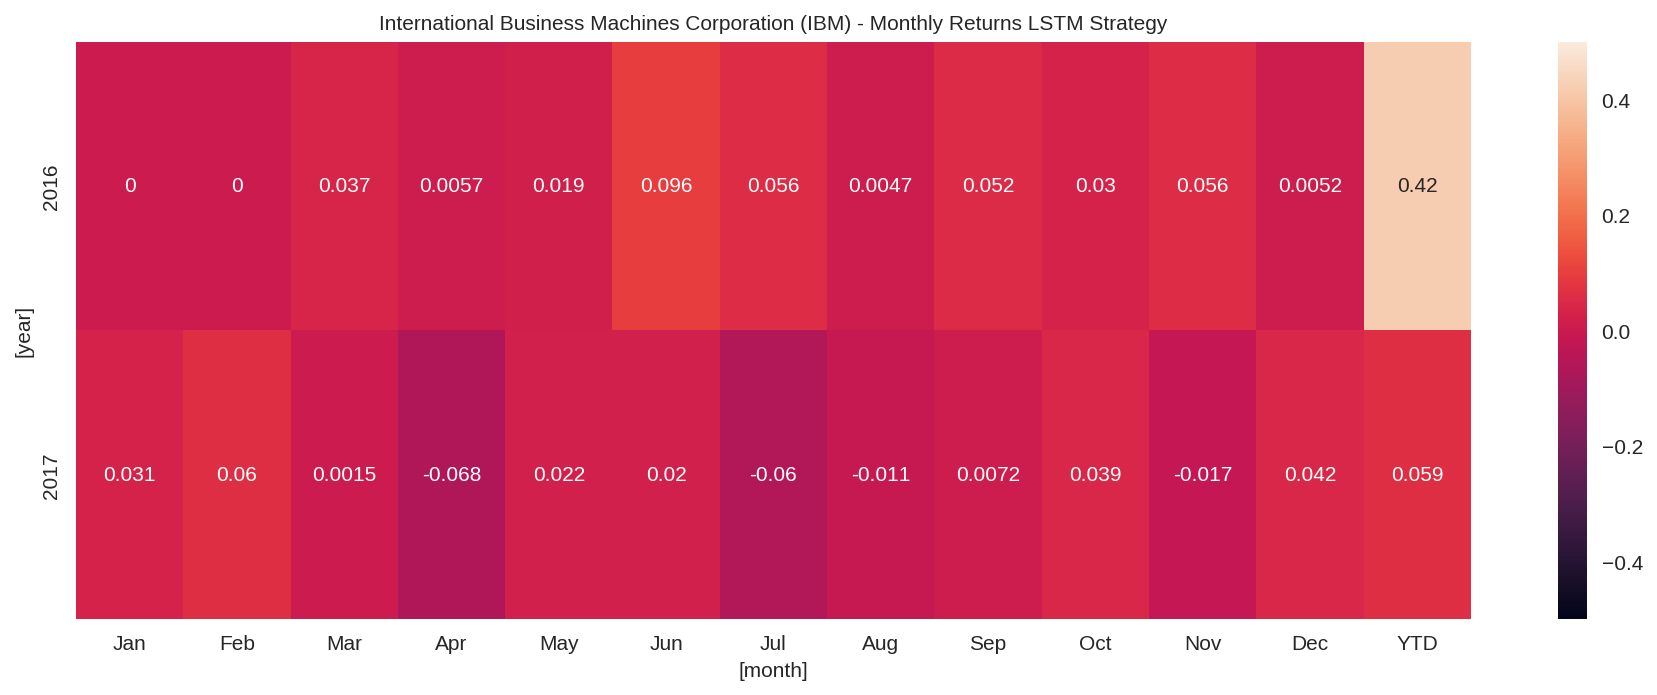

In [99]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
ax = sns.heatmap(backtest_lstm.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
ax.set_xlabel('[month]', fontsize=10)
ax.set_ylabel('[year]', fontsize=10)

# set plot title
ax.set_title('International Business Machines Corporation (IBM) - Monthly Returns LSTM Strategy', fontsize=10);

Collect detailed backtest performance per timestep of the "buy-and-hold" trading strategy:

In [100]:
backtest_base_details = backtest_base.strategy.prices.to_frame(name='Rel. EQUITY')
backtest_base_details['Abs. EQUITY'] = backtest_base.strategy.values # equity per timestep
backtest_base_details['CASH'] = backtest_base.strategy.cash # cash per timestep
backtest_base_details['POSITIONS'] = backtest_base.strategy.positions # positions per timestep
backtest_base_details['FEES'] = backtest_base.strategy.fees # trading fees per timestep

Inspect the "buy-and-hold" trading strategy backtest details:

In [101]:
backtest_base_details.head(10)

,Rel. EQUITY,Abs. EQUITY,CASH,POSITIONS,FEES
2016-03-15,100.000000,1.000000e+06,1000000.000000,0.0,0.0
2016-03-16,100.000000,1.000000e+06,1000000.000000,0.0,0.0
2016-03-17,100.000000,1.000000e+06,99.923462,7113.0,0.0
2016-03-18,100.034004,1.000340e+06,99.923462,7113.0,0.0
2016-03-19,100.034004,1.000340e+06,99.923462,7113.0,0.0
2016-03-20,100.034004,1.000340e+06,99.923462,7113.0,0.0
2016-03-21,101.081233,1.010812e+06,99.923462,7113.0,0.0
2016-03-22,100.720829,1.007208e+06,99.923462,7113.0,0.0
2016-03-23,98.884773,9.888477e+05,99.923462,7113.0,0.0
2016-03-24,100.618817,1.006188e+06,99.923462,7113.0,0.0


Visualize the monthly returns obtained by the "buy-and-hold" trading strategy:

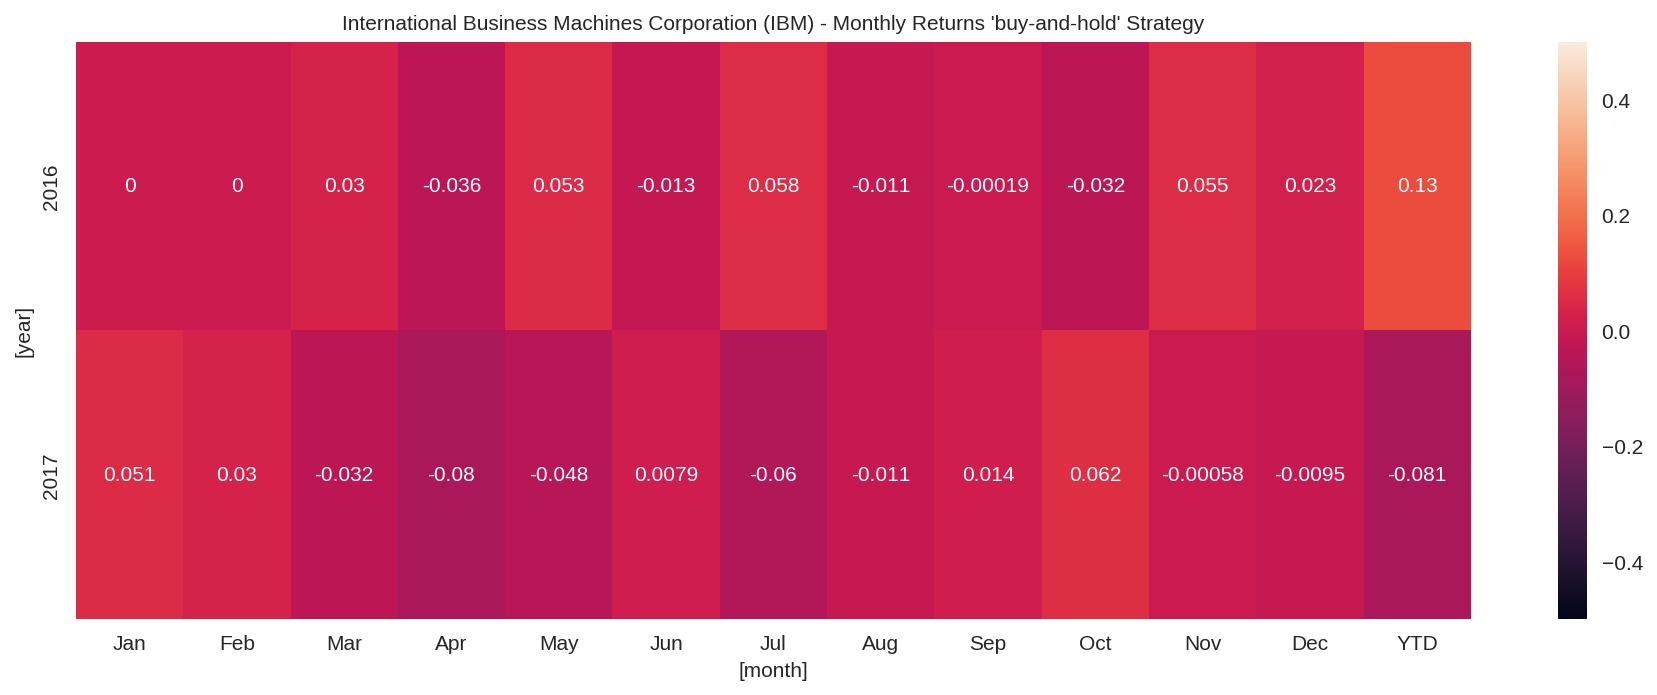

In [102]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
ax = sns.heatmap(backtest_base.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
ax.set_xlabel('[month]', fontsize=10)
ax.set_ylabel('[year]', fontsize=10)

# set plot title
ax.set_title('International Business Machines Corporation (IBM) - Monthly Returns \'buy-and-hold\' Strategy', fontsize=10);

Visualize the equity progression of both strategies over time:

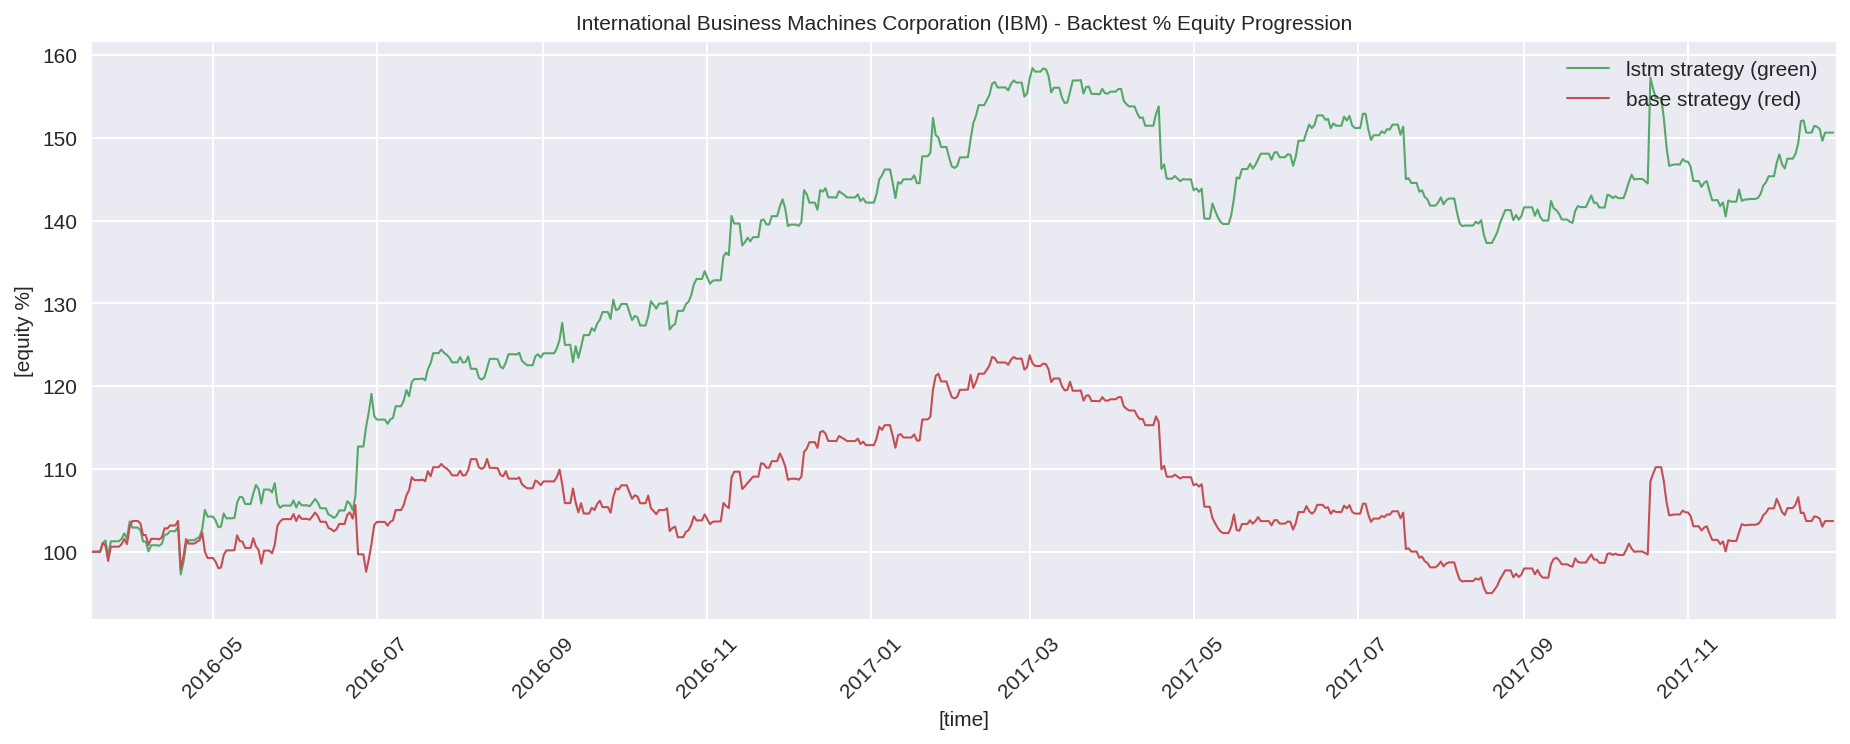

In [103]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(backtest_lstm_details['Rel. EQUITY'], color='C1',lw=1.0, label='lstm strategy (green)')
ax.plot(backtest_base_details['Rel. EQUITY'], color='C2',lw=1.0, label='base strategy (red)')

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim(valid_stock_sequence_data_date[:, -1].min(), valid_stock_sequence_data_date[:, -1].max())
ax.set_ylabel('[equity %]', fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# set plot title
plt.title('International Business Machines Corporation (IBM) - Backtest % Equity Progression', fontsize=10);